#  Biodiversity Intactness Index change in Phoenix, AZ

Using Biodiversity Intactness Index (BII) from the Microsoft Planetary Computer STAC catalog and Phoenix Subdivision Shapefile to measure changes in biodiversity in Phoenix, Arizona

Author: Michelle Yiv

For further information and content about this analysis, view this [GitHub repository.](https://github.com/mmyiv/Changes-in-Biodiversity-Intactness-in-Arizona)


![Arizona Landscape. Source: azsustainabilityalliance.com](https://i0.wp.com/www.azsustainabilityalliance.com/wp-content/uploads/2019/05/Arizona_Biodiversity.jpeg?resize=1170%2C777&ssl=1)


#### Purpose

In 2021, areas within Phoenix county were identified with having the most increase in developed land since 2001. This urbanization has had major effects on the surrounding environment, suggesting negative impacts on biodiversity and ecosystems.

This notebook will focus on analyzing the impact of urbanization on biodiversity, focusing on the loss of biodiversity from 2017 to 2021 using the MPAC STAC catalog Biodiversity Intactness Index in the Phoenix, Arizona county subdivision.

#### Analysis Highlights

- Accessing the MPAC STAC catalog's `io-biodiversity` collection using `pystac_client` and `planetary computer` to access 2017 and 2022 BII maps.

- Mapping Phoenix County subdivision with geographic context using `contextily`, and later using this to outline the change in biodiversity map.

- Calculating percentage of area with BII loss greater than 75% in 2017 and 2020. The number of pixels were counted using `.count().item` and `.sum().item` for the whole and part respectively. These values would be used to map the areas of significant BII loss.

- Visualizing BII loss by first finding the difference between BII in years 2017 and 2020. Selecting pixels that were present in 2017 but not 2020 indicate loss, and were mapped in contrast to the 2020 raster.

#### Datasets used

**1. Biodiversity Intactness Index (BII) Time Series**

Biodiversity intactness index data was accessed by the [ Microsoft Planetary Computer STAC catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity), where the `io-biodiversity` is used in this analysis. This data contains terrestrial Biodiversity Intactness maps from 2017 to 2020. It was used to visualize the rasters from 2017 and 2020.

**2. Phoenix Subdivision Shapefile** 

Phoenix shapefile was obtained from the United States Census Bureau Tiger/Shapeline files. County subdivision census data from 2024 was used to filter to our area of interest. The shapefile was used as a basemap to indicate the border of Phoenix county.


#### References to datasets
Microsoft Planetary Computer, STAC Catalog. Biodiversity Intactness. [Dataset].   https://planetarycomputer.microsoft.com/dataset/io-biodiversity. Accessed 5 December 2024.

United States Census Bureau. 2024. Arizona County TIGER/Line Shapefiles. [Dataset]. United States Census Bureau. https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html. Accessed 5 December 2024.

C. Galaz García, EDS 220 - Working with Environmental Datasets, Course Notes. 2024. [Online]. https://meds-eds-220.github.io/MEDS-eds-220-course/book/preface.html. Accessed 5 December 2024.

## Set up

### Import packages

In [1]:
# Import packages

import numpy as np
import geopandas as gpd
import os

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

import rioxarray as rioxr
from shapely import box

import pystac_client
import planetary_computer

from IPython.display import Image
import contextily as cx

### Read in data

In [2]:
# Read in shapefile for Arizona
fp = os.path.join('data','tl_2024_04_cousub.shp')
county = gpd.read_file(fp)

In [3]:
# Access data from MPC
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Data Exploration

#### BII Data

In [4]:
# Set time range
time_range = "2017-01-01/2020-01-01"

# Set bbox according to course website
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Catalog search
search = catalog.search(
    collections=["io-biodiversity"], 
    bbox=bbox, 
    datetime = time_range)

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 4 Items


In [5]:
# Get first item in the catalog search for year 2020
item = items[0]

# View assets of each item
for key in item.assets.keys():
    print(key, '--', item.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


Results from exploration:

Viewing assets for all items tells me that I will use `data` to access the raster data using `rioxr.open_rasterio()`.
Clicking through the items gives information on geometries, coordinates, and bbox. In particular, the properties tab tells me the year associated with each raster. I will use this to differentiate each raster through subsetting.

#### Arizona County Subdivision data

In [6]:
# View the first few rows
county.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,0600000US0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,S,12231962349,44576380,+35.1066122,-111.3662507,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,0600000US0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,S,7228864156,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,0600000US0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."
3,04,023,92295,01934961,0402392295,0600000US0402392295,Nogales,Nogales CCD,22,Z5,G4040,S,1762339489,2382710,+31.4956020,-111.0171332,"POLYGON ((-111.36692 31.52136, -111.36316 31.5..."
4,04,023,92550,01934966,0402392550,0600000US0402392550,Patagonia,Patagonia CCD,22,Z5,G4040,S,1439560139,685527,+31.5664619,-110.6410279,"POLYGON ((-110.96273 31.68695, -110.96251 31.6..."


In [7]:
# Update column names to lower case
county.columns = county.columns.str.lower()

In [8]:
# Check column types
county.dtypes

statefp       object
countyfp      object
cousubfp      object
cousubns      object
geoid         object
geoidfq       object
name          object
namelsad      object
lsad          object
classfp       object
mtfcc         object
funcstat      object
aland          int64
awater         int64
intptlat      object
intptlon      object
geometry    geometry
dtype: object

In [9]:
# Filter to Phoenix county subdivision
ph = county[county['name'] == 'Phoenix']

In [10]:
# Check CRS for future reference
ph.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

Results from exploration:

I started by viewing the first few rows to check column names and to get a general idea of the data. I needed to filter to Phoenix county, there I needed to know which columns I should filter by. I changed column names to lowercase for good coding practices and to make filtering easier. I checked the types of each column to ensure that names were strings that I could filter by.
Finally, I checked the CRS of the dataset because I knew that I would have to plot with this data. By checking the CRS ahead of time, I avoid errors and I know to match CRS with the biodiversity dataset.

## Map of Phoenix Subdivision

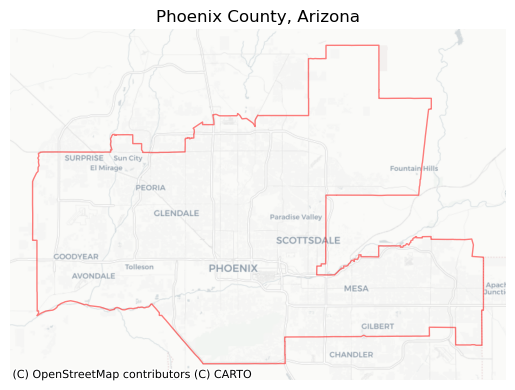

In [11]:
# Initialize plot
fig, ax = plt.subplots()

# Plot Phoenix, AZ County border
(ph.to_crs(epsg=3857).plot(ax=ax, 
                           edgecolor="red", 
                           facecolor='none',
                           alpha = 0.5, 
                           figsize=(9, 9)))

# Add basemap from contextily
cx.add_basemap(ax=ax, source = cx.providers.CartoDB.Positron) 

# Add title and turn off axis
ax.set_title("Phoenix County, Arizona")
ax.set_axis_off()

plt.show()

Figure caption: Border of Phoenix County Subdivision in Arizona with geographic context.

### BII Analysis

#### 2017

In [12]:
# Get third item in the catalog search for year 2017
item = items[3]

In [13]:
# Access 2017 raster data from item
bio_2017 = rioxr.open_rasterio(item.assets['data'].href)
bio_2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [14]:
# Remove length 1 dimension (band)
bio_2017 = bio_2017.squeeze().drop_vars('band')

In [15]:
# Match CRSs and verify update
ph_match = ph.to_crs(bio_2017.rio.crs)

assert bio_2017.rio.crs == ph_match.crs

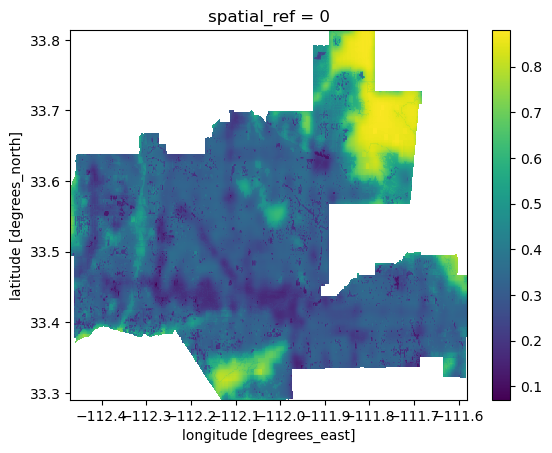

In [16]:
# Clip raster to match Phoenix 
bio_2017_clip = (bio_2017.rio.clip_box(*ph_match.total_bounds)
                 .rio.clip(ph_match.geometry))
# View
bio_2017_clip.plot()

#### 2020

In [17]:
# Get first item in the catalog search - 2020
item2 = items[0]

In [18]:
# Access raster data from item
bio_2020 = rioxr.open_rasterio(item2.assets['data'].href)
bio_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [19]:
# Remove length 1 dimension (band)
bio_2020 = bio_2020.squeeze().drop_vars('band')

In [20]:
# Match CRSs and verify update
ph_match = ph.to_crs(bio_2020.rio.crs)

assert bio_2020.rio.crs == ph_match.crs

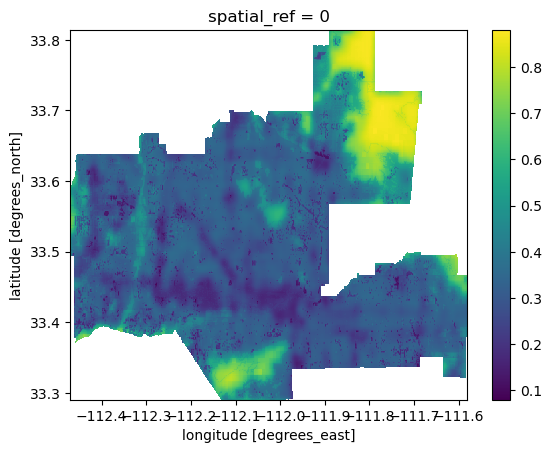

In [21]:
# Clip raster to match Phoenix 
bio_2020_clip = (bio_2020.rio.clip_box(*ph_match.total_bounds)
                         .rio.clip(ph_match.geometry))
# View
bio_2020_clip.plot()

## Calculating the difference in percentage of BII area >0.75 between 2017 and 2020

#### Calculate percentage area for 2017

In [22]:
# Identify BII values greater than 0.75 for 2017
bio_2017_bii = (bio_2017_clip >= 0.75).astype(int)

In [23]:
# Find total number of pixels
total_2017 = bio_2017_clip.count().item()

# Find pixels with bii > 0.75
values_2017 = bio_2017_bii.sum().item() # sum() adds pixels that are >0.75

# Calculate percentage (part/whole)
pct_2017 = round((values_2017/total_2017) * 100, 2)

print("The percentage of Phoenix subdivision with a BII >= 0.75 in 2017 is ", round(pct_2017, 2), "%")

The percentage of Phoenix subdivision with a BII >= 0.75 in 2017 is  7.13 %


#### Calculate percentage area for 2020

In [24]:
# Identify BII values greater than 0.75 for 2020
bio_2020_bii = (bio_2020_clip >= 0.75).astype(int)

In [25]:
# Find total number of pixels
total_2020 = bio_2020_clip.count().item()

# Find pixels with bii > 0.75
values_2020 = bio_2020_bii.sum().item() # sum() adds pixels that are >0.75

# Calculate percentage (part/whole)
pct_2020 = (values_2020 / total_2020) * 100

print("The percentage of Phoenix subdivision with a BII >= 0.75 in 2020 is ", round(pct_2020, 2), "%")

The percentage of Phoenix subdivision with a BII >= 0.75 in 2020 is  6.49 %


#### Visualize BII loss

In [26]:
# Calculate loss from 2017 to 2020
pct_diff = bio_2017_bii - bio_2020_bii

To visualize the loss, refer to diagram from course website:

![Raster Difference. Source: EDS220 Course Website](https://meds-eds-220.github.io/MEDS-eds-220-course/assignments/images/bii_raster_math.png)

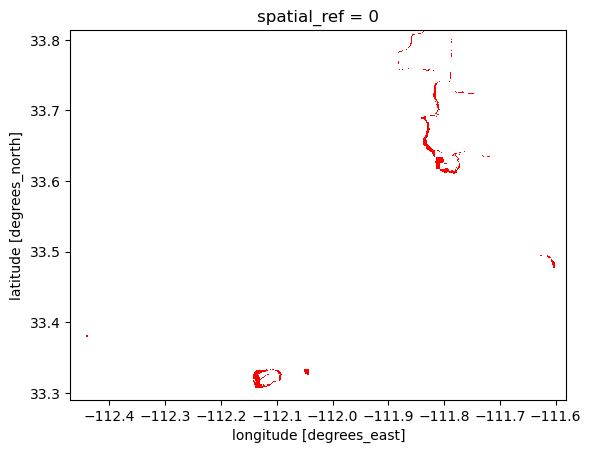

In [27]:
# Have BII >0.75 in 2017 set to 1 as it represents bii loss
bii_loss = pct_diff == 1

# Convert to integer to actually be able to plot
bii_loss = bii_loss.astype(int)

# Apply cmap to plot

# Make dictionary of colors
colors = {
    0: "none",        # No Data
    1: "red",         # Bii loss 
}
    
# Create a ListedColormap
cmap = ListedColormap([colors[key] for key in sorted(colors.keys())])

# View updated inital plot
bii_loss.plot(cmap = cmap, add_colorbar = False)   

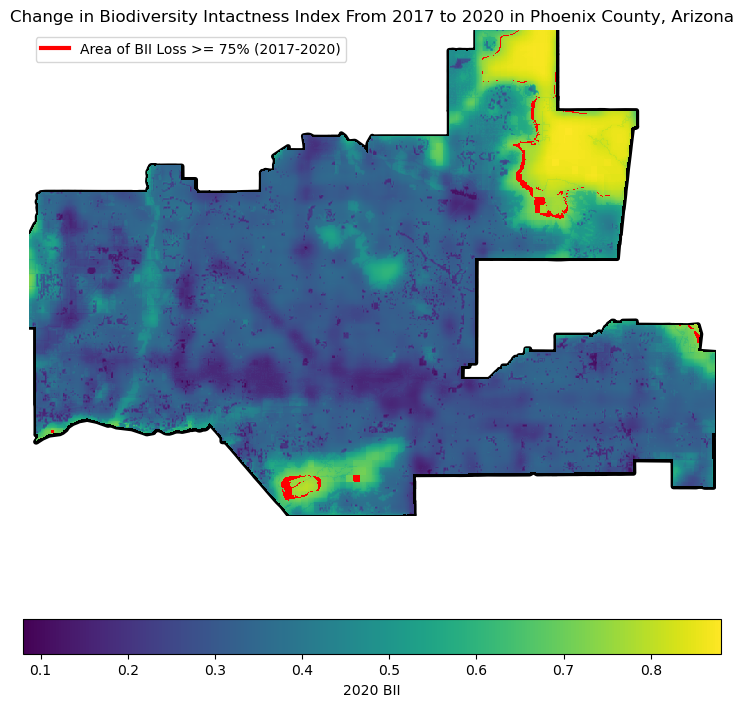

In [28]:
# Initialize plot
fig, ax = plt.subplots(figsize = (9,9))

# Add Phoenix, AZ basemap from step 1
ph.plot(ax=ax,
       edgecolor = 'black',
       linewidth = 4)

# Add 2020 biodiversity as base layer
bio_2020_clip.plot(ax = ax,
                  cbar_kwargs = {"location": "bottom",
                                 "label": "2020 BII"})
# Add BII difference (from above)
bii_loss.plot(ax = ax,
              cmap = cmap, 
              add_colorbar = False)  

# Add legend
custom_legend = Line2D([0], [0], color='red', lw=3, label='Area of BII Loss >= 75% (2017-2020)') 
ax.legend(handles=[custom_legend], loc='upper left', fontsize=10)

# Turn off axis
ax.set_axis_off()

# Set title
ax.set_title("Change in Biodiversity Intactness Index From 2017 to 2020 in Phoenix County, Arizona")

plt.show()

Results:
After obtaining the border for the Phoenix County Subdivision through the US Census Bureau shapefile, raster data from MPAC STAC `io-biodiversity` collection was used to calculate differences in significant biodiversity loss from 2017 to 2020. The areas with significant BII loss are labeled in red on the map above. There are a few main areas with significant loss, seen in areas south of Phoenix City and northwest from Footland hills, indicating that these are likely areas that have been urbanized and caused subsequent environmental impact.